# Analysis for salmon trap data in the Dungenesss River from 2005-2014
### Description of data:
Data is stored in MS Excel files with one sheet per year. For 2005, the counts for both wild and hatchery are together with an additional column for wild fish. For all other years, counts for wild and hatchery fish are separate.



In [134]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
# #read file in Windows
# try:
#     df_2005 = pd.read_excel(
#    io="C:/Users/maria/OneDrive/Documents/data/pied_piper/Dungeness smolt trap 2005 - 2014.xlsx",
#    sheet_name ='2005',
#     header = [3,4]
# )
# except PermissionError:
#     print("Permission Error. Close the file, if it is open.")
    

# df_2005.head()
#columns = list(df)

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,Chinook 0+,Chinook 1+,Chum,Coho 0+,Coho 1+,Pink,...,Coho 1+ Hatchery ad-mark,Coho 1+ hatchery CWT not ad-marked,Cutthroat parr unmark wild,Cutthroat adult unmark wild,Steelhead parr unmark wild,Steelhead smolt UC mark wild,Steelhead hatchery ad-mark,Steelhead adult unmark wild,Dolly Varden / Bull trout parr unmark wild,Dolly Varden / Bull trout smolt unmark wild
,Down,Up,In,Out,10,11,20,40,41,30,...,41\13,41\30,60\0,62\0,70\0,71\08,71\13,73\0,90\0,91\0
0,2005-03-08 16:30:00,2005-03-09 12:14:00,19.733333,0.000000,86.0,0.0,268.0,0.0,0.0,106.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,2005-03-09 12:14:00,2005-03-09 13:06:00,0.000000,0.866667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-03-09 13:06:00,2005-03-09 18:20:00,5.233333,0.000000,1.0,0.0,30.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-03-09 18:20:00,2005-03-09 20:13:00,1.883333,0.000000,7.0,0.0,165.0,0.0,0.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-03-09 20:13:00,2005-03-10 08:41:00,12.466667,0.000000,53.0,0.0,599.0,0.0,0.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
#if using linux machine:
df_2005 = pd.read_excel(
   io="/home/maria/Documents/data/pied_piper/Dungeness smolt trap 2005 - 2014.xlsx",
   sheet_name ='2005',
    header = [3,4]
)
df_2005.head()
df_2005.columns

MultiIndex([(                         'Unnamed: 0_level_0',  'Down'),
            (                         'Unnamed: 1_level_0',    'Up'),
            (                         'Unnamed: 2_level_0',    'In'),
            (                         'Unnamed: 3_level_0',   'Out'),
            (                                 'Chinook 0+',      10),
            (                                 'Chinook 1+',      11),
            (                                       'Chum',      20),
            (                                    'Coho 0+',      40),
            (                                   'Coho 1+ ',      41),
            (                                       'Pink',      30),
            (                                    'Sockeye',      50),
            (                                 'Trout parr',      65),
            (                           'Steelhead smolts',      71),
            (                           'Cutthroat smolts',      61),
            (       

In [145]:
df_2005.columns = df_2005.columns.droplevel(level=1)
df_2005.rename(columns = {
    'Unnamed: 0_level_0':'Down',
    'Unnamed: 1_level_0':'Up',
    'Unnamed: 2_level_0':'In',
    'Unnamed: 3_level_0':'Out',
    'Coho 1+ ':'Coho 1+'
}, inplace = True)
df_2005['Date'] = df_2005['Down'].dt.date
groupedby_dates_2005 = df_2005.groupby(by=["Date"]).sum()
groupedby_dates_2005 = groupedby_dates_2005[groupedby_dates_2005['Out'] == 0]
groupedby_dates_2005.fillna(0)

,In,Out,Chinook 0+,Chinook 1+,Chum,Coho 0+,Coho 1+,Pink,Sockeye,Trout parr,...,Coho 1+ Hatchery ad-mark,Coho 1+ hatchery CWT not ad-marked,Cutthroat parr unmark wild,Cutthroat adult unmark wild,Steelhead parr unmark wild,Steelhead smolt UC mark wild,Steelhead hatchery ad-mark,Steelhead adult unmark wild,Dolly Varden / Bull trout parr unmark wild,Dolly Varden / Bull trout smolt unmark wild
Date,,,,,,,,,,,,,,,,,,,,,
2005-03-08,19.733333,0.0,86.0,0.0,268.0,0.0,0.0,106.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2005-03-10,23.300000,0.0,25.0,0.0,562.0,0.0,0.0,40.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2005-03-11,24.266667,0.0,119.0,0.0,1038.0,0.0,0.0,75.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-03-12,22.866667,0.0,91.0,0.0,692.0,0.0,0.0,24.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2005-03-13,24.466667,0.0,127.0,0.0,791.0,0.0,0.0,38.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-07-19,24.000000,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-07-22,23.500000,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-07-28,23.833333,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


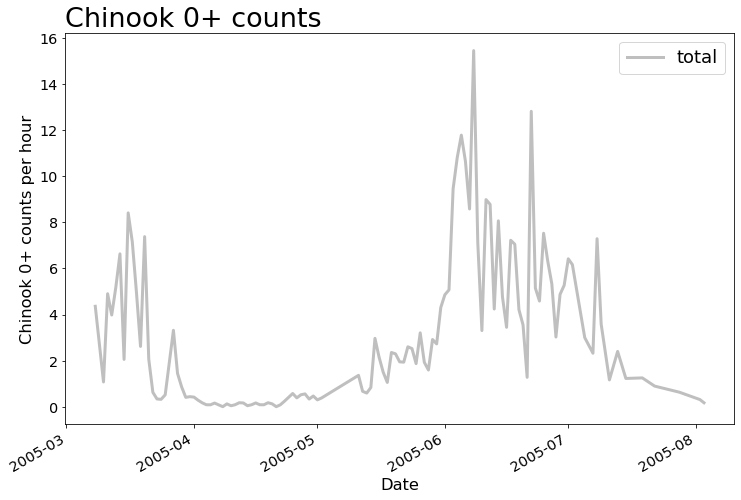

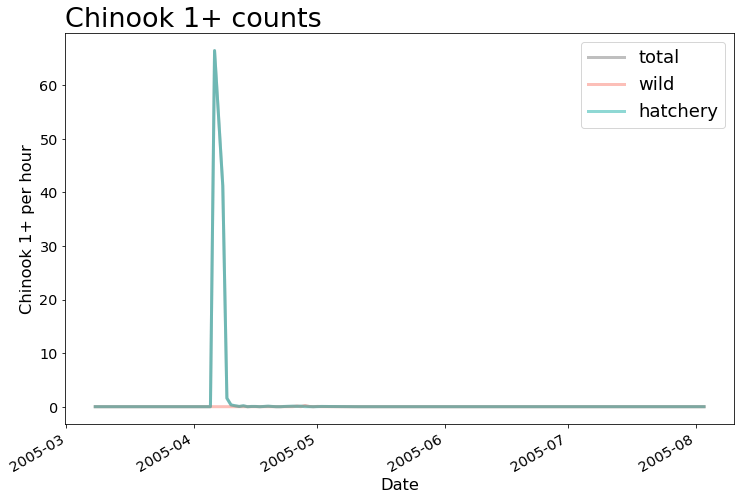

In [151]:
#Chinook 
groupedby_dates_2005['chinook1_perhour'] = groupedby_dates_2005['Chinook 1+']/groupedby_dates_2005['In']
groupedby_dates_2005['chinook1_hatchery_perhour'] = groupedby_dates_2005['Chinook 1+ CWT hatchery']/groupedby_dates_2005['In']
groupedby_dates_2005['chinook1_wild_perhour'] = groupedby_dates_2005['chinook1_perhour'] - groupedby_dates_2005['chinook1_hatchery_perhour']

#chinook 0
groupedby_dates_2005['chinook0_perhour'] = groupedby_dates_2005['Chinook 0+']/groupedby_dates_2005['In']



fs = 18
lw = 3
tranparency = 0.5
plt.close('all') # always start by cleaning up
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['chinook0_perhour'], color = 'gray',
    label = 'total', alpha = 0.5, linewidth = lw)
plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Chinook 0+ counts per hour', size = 0.9*fs)
ax1.tick_params(labelsize=.8*fs)
ax1.set_title('Chinook 0+ counts', loc='left', fontsize = fs*1.5)
plt.legend(fontsize=fs, loc='upper right', title = '')

plt.show()


#chinook1
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['chinook1_perhour'], 
    linewidth = 3, label = 'total', color = 'gray', alpha = transparency)
ax.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['chinook1_wild_perhour'], 
    linewidth = 3, label = 'wild', color = 'salmon', alpha = transparency)

ax.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['chinook1_hatchery_perhour'], 
    linewidth = 3, label  = 'hatchery', color = 'lightseagreen', alpha = transparency)

plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Chinook 1+ per hour', size = 0.9*fs)
ax.tick_params(labelsize=.8*fs)
ax.set_title('Chinook 1+ counts', loc='left', fontsize = fs*1.5)
plt.legend(fontsize=fs, loc='upper right', title = '')


plt.show()


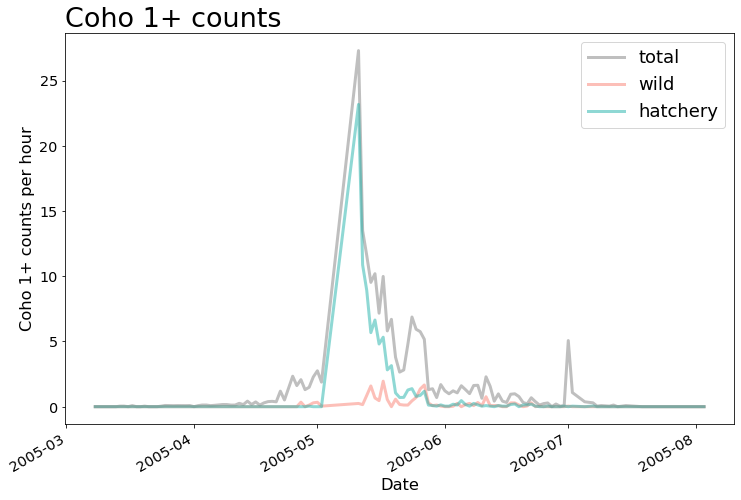

In [150]:
#Coho
groupedby_dates_2005['coho1_perhour'] = groupedby_dates_2005['Coho 1+']/groupedby_dates_2005['In']

groupedby_dates_2005['Coho 1+ UC mark Wild per hour'] = (
    groupedby_dates_2005['Coho 1+ UC mark Wild']/groupedby_dates_2005['In'])

groupedby_dates_2005['Coho 1+ LC mark Wild per hour'] = (
    groupedby_dates_2005['Coho 1+ LC mark Wild']/groupedby_dates_2005['In'])

groupedby_dates_2005['coho1_wild_perhour'] = (
    groupedby_dates_2005['Coho 1+ UC mark Wild per hour'] + groupedby_dates_2005['Coho 1+ LC mark Wild per hour'])

groupedby_dates_2005['Coho 1+ Hatchery ad-mark per hour'] = (
    groupedby_dates_2005['Coho 1+ Hatchery ad-mark']/groupedby_dates_2005['In'])

groupedby_dates_2005['Coho 1+ hatchery CWT not ad-marked per hour'] = (
    groupedby_dates_2005['Coho 1+ hatchery CWT not ad-marked']/groupedby_dates_2005['In'])

groupedby_dates_2005['coho1_hatchery_perhour'] = (
    groupedby_dates_2005['Coho 1+ Hatchery ad-mark per hour'] + groupedby_dates_2005['Coho 1+ hatchery CWT not ad-marked per hour'])

lw = 3
plt.close('all') # always start by cleaning up
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['coho1_perhour'], color = 'gray', 
    label = 'total', alpha = 0.5, linewidth = lw)

ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['coho1_wild_perhour'], color = 'salmon', 
    label = 'wild', alpha = 0.5, linewidth = lw)


ax1.plot(groupedby_dates_2005.index, groupedby_dates_2005['coho1_hatchery_perhour'], color = 'lightseagreen', 
         label = 'hatchery', alpha = 0.5, linewidth = lw)

plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Coho 1+ counts per hour', size = 0.9*fs)
ax1.tick_params(labelsize=.8*fs)
ax1.set_title('Coho 1+ counts', loc='left', fontsize = fs*1.5)
plt.legend(fontsize=fs, loc='upper right', title = '')

plt.show()


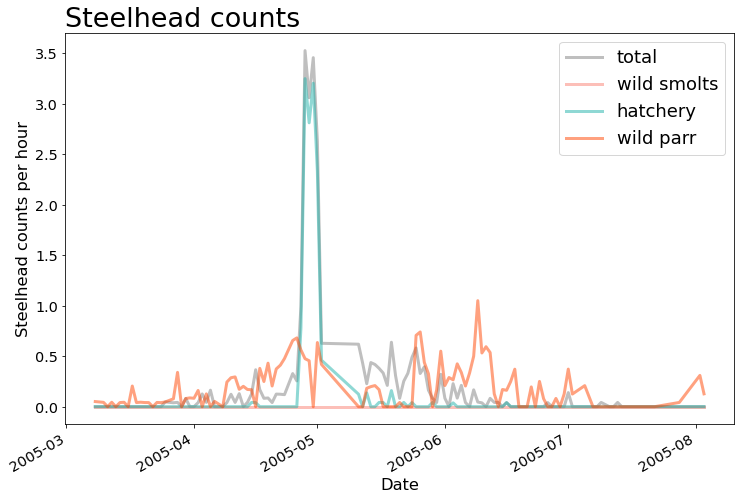

In [154]:
#Steelhead
groupedby_dates_2005['steelheadsmolt_perhour'] = (
    groupedby_dates_2005['Steelhead smolts']/groupedby_dates_2005['In'])

groupedby_dates_2005['steelheadsmolt_wild_perhour'] = (
    groupedby_dates_2005['Steelhead smolt UC mark wild']/groupedby_dates_2005['In'])

groupedby_dates_2005['steelhead_hatchery_perhour'] = (
    groupedby_dates_2005['Steelhead hatchery ad-mark']/groupedby_dates_2005['In'])

groupedby_dates_2005['steelheadparr_perhour'] = (
    groupedby_dates_2005['Steelhead parr unmark wild']/groupedby_dates_2005['In'])

fs = 18
lw = 3
transparency = 0.5
plt.close('all') # always start by cleaning up
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['steelheadsmolt_perhour'], color = 'gray', 
    label = 'total', alpha = 0.5, linewidth = lw)

ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['steelheadsmolt_wild_perhour'], color = 'salmon', 
    label = 'wild smolts', alpha = 0.5, linewidth = lw)


ax1.plot(groupedby_dates_2005.index, groupedby_dates_2005['steelhead_hatchery_perhour'], color = 'lightseagreen', 
         label = 'hatchery', alpha = 0.5, linewidth = lw)

ax1.plot(groupedby_dates_2005.index, groupedby_dates_2005['steelheadparr_perhour'], color = 'orangered', 
         label = 'wild parr', alpha = 0.5, linewidth = lw)

plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Steelhead counts per hour', size = 0.9*fs)
ax1.tick_params(labelsize=.8*fs)
ax1.set_title('Steelhead counts', loc='left', fontsize = fs*1.5)
plt.legend(fontsize=fs, loc='upper right', title = '')

plt.show()

In [226]:
#reading html data
from urllib.request import urlopen
from bs4 import BeautifulSoup
import io

year = '2005'
url = "https://apps.ecology.wa.gov/ContinuousFlowAndWQ/StationData/Prod/18A050/18A050_" + year + "_WTM_FM.TXT"
html = urlopen(url).read()
soup = BeautifulSoup(html, features="html.parser")

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()

text = text[131:]

df = pd.read_csv(io.StringIO(text), sep='\s+', header = None, names = ["date", "time", "temp", "quality"])
df['datetime'] =  pd.to_datetime(df['date'] + ' ' + df['time'])

In [251]:
df_2005['midpoint'] = df_2005['Down'] + (df_2005['Up'] - df_2005['Down'])/2

In [298]:
from datetime import date
df['hour'] = df['datetime'].dt.hour
df_2005_hour=df.groupby(by=["date","hour"]).mean()
# print(df_2005_hour)
d= date(2005,8,6)
hour = 2
print(df_2005_hour['temp'].loc[datetime.strftime(d,format = "%m/%d/%Y"),hour])

14.475


In [307]:
df_2005['midpoint_date']= df_2005['midpoint'].dt.date
df_2005['midpoint_hour']= df_2005['midpoint'].dt.hour
df_2005_hour.rename(index={"date": "midpoint_date", "hour": "midpoint_hour"})
df_2005_temp = pd.merge(df_2005, df_2005_hour, how="left", on=["midpoint_date", "midpoint_hour"])
df_2005_temp.head()

KeyError: 'midpoint_date'

In [320]:
# get text
text = soup.get_text()

text = text[131:]

df = pd.read_csv(io.StringIO(text), sep='\s+', header = None, names = ["date", "time", "temp", "quality"])
df['midpoint'] =  pd.to_datetime(df['date'] + ' ' + df['time'])

df_2005.set_index('midpoint')


df_2005_temp = pd.merge_asof(df_2005.dropna(subset = ['midpoint']),df, on="midpoint",tolerance=pd.Timedelta("10ms"))
df_2005_temp.head()

,Down,Up,In,Out,Chinook 0+,Chinook 1+,Chum,Coho 0+,Coho 1+,Pink,...,Dolly Varden / Bull trout parr unmark wild,Dolly Varden / Bull trout smolt unmark wild,Date,midpoint,midpoint_date,midpoint_hour,date,time,temp,quality
0,2005-03-08 16:30:00,2005-03-09 12:14:00,19.733333,0.000000,86.0,0.0,268.0,0.0,0.0,106.0,...,NaN,NaN,2005-03-08,2005-03-09 02:22:00,2005-03-09,2.0,NaN,NaN,NaN,NaN
1,2005-03-09 12:14:00,2005-03-09 13:06:00,0.000000,0.866667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2005-03-09,2005-03-09 12:40:00,2005-03-09,12.0,NaN,NaN,NaN,NaN
2,2005-03-09 13:06:00,2005-03-09 18:20:00,5.233333,0.000000,1.0,0.0,30.0,0.0,0.0,2.0,...,NaN,NaN,2005-03-09,2005-03-09 15:43:00,2005-03-09,15.0,NaN,NaN,NaN,NaN
3,2005-03-09 18:20:00,2005-03-09 20:13:00,1.883333,0.000000,7.0,0.0,165.0,0.0,0.0,33.0,...,NaN,NaN,2005-03-09,2005-03-09 19:16:30,2005-03-09,19.0,NaN,NaN,NaN,NaN
4,2005-03-09 20:13:00,2005-03-10 08:41:00,12.466667,0.000000,53.0,0.0,599.0,0.0,0.0,56.0,...,NaN,NaN,2005-03-09,2005-03-10 02:27:00,2005-03-10,2.0,NaN,NaN,NaN,NaN


In [323]:
pd.Timedelta("10ms")
#still need to merge

Timedelta('0 days 00:00:00.010000')